# Hackathon #1 - Binary Classification - Template
Always check the [Reference Document](https://docs.google.com/document/d/1A-1-UK9ol4tegfU4YQySEiBXBeqbx_tu1qdmiMAzNCM/edit?usp=sharing) for all information ;) 

Remember to keep your workflow consistent!

## Regarding the Data
- The dataset can be loaded with `load_data()` (check the already provided code below). It will output two dataframes:
  - `train`: labeled dataset (with target) 
  - `test`: unlabeled dataset (target is not available)
- You will use the `train` data to do your magic! When you are finished and have a predictive model you will have to make predictions using the `test` data and submit it to our platform (where you will get a AUC value - kind of what happens in Kaggle competitions). Check the file `submission_example.csv` for an example and the [Reference Document](https://docs.google.com/document/d/1A-1-UK9ol4tegfU4YQySEiBXBeqbx_tu1qdmiMAzNCM/edit?usp=sharing) for further information.
- You can and should perform train-test splits on the `train` data that you have available. Cross-validation is highly recommended. 
- The target name is `TomorrowRainForecast`: it is either 1 (rains tomorrow) and 0 (does not rain tomorrow).
- The `ID` is the identification variable which is very important for keeping track of the predictions you will make on the `test` data.

*Good luck,  
LDSA team*

In [1]:
# some useful imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_data(data_dir='./data/'):
    train = pd.read_csv(data_dir+'train.csv')
    test = pd.read_csv(data_dir+'test.csv')
    return train, test

# -1. Load Data
Load the `train` and `test` datasets

In [3]:
train, test = load_data()

In [4]:
train.head()

,ID,AmountRain,StrongWindDir,StrongWindSpeed,MorningWindDir,AfternoonWindDir,AfternoonWindSpeed,MorningHumidity,AfternoonHumidity,MorningTemp,AfternoonTemp,DidRainToday,DaysSinceNewYear,TomorrowRainForecast
0,5683,0.0,WSW,43.0,N,SW,17.0,82.0,51.0,15.4,20.8,No,268,0
1,2971,0.0,E,15.0,NaN,SE,7.0,91.0,63.0,9.7,16.6,No,136,0
2,3560,0.0,S,33.0,WSW,WSW,17.0,58.0,38.0,10.9,15.9,No,217,0
3,2304,10.0,NE,30.0,S,SSE,11.0,96.0,93.0,4.7,6.4,Yes,195,1
4,3573,0.0,WSW,48.0,NaN,SW,26.0,59.0,40.0,11.5,15.9,No,232,0


# 0.Train Test Split

In [5]:
from sklearn.model_selection import train_test_split

# Split the training dataset into X and Y.
X = train.drop(['TomorrowRainForecast', 'ID'], axis=1)
y = train['TomorrowRainForecast']

submission_id = test.pop('ID')


# Split the Cross Validation set from the train. The overall distribution within datasets:
# 60% Train, 20% Cross Validation, 20% Test
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2*len(X)/len(X_train))

In [6]:
print('Datasets number of rows:\n  X_train: %.0f\n  X_cv: %.0f\n  X_test: %.0f' % (len(X_train), len(X_cv), len(X_test)))

Datasets number of rows:
  X_train: 4171
  X_cv: 1391
  X_test: 1391


# 1. Preprocessing

In [7]:
# Get the list of categorical and numerical columns.
categoricals = X.select_dtypes(include=['object'])
categoricals = list(categoricals.columns)

numericals = X.select_dtypes(exclude=['object'])
numericals = list(numericals.columns)


def fill_nas(_df_train, _df_cv, _df_test, _final_test, categoricals, numericals):
    # _df_test is the training subset designed for testing
    # _final_test is the testing dataset
    _df_train = _df_train.copy()
    _df_cv = _df_cv.copy()
    _df_test = _df_test.copy()
    _final_test = _final_test.copy()
    
    for c in categoricals:
        _df_train[c] = _df_train[c].fillna('unknown')
        _df_cv[c] = _df_cv[c].fillna('unknown')
        _df_test[c] = _df_test[c].fillna('unknown')
        _final_test[c] = _final_test[c].fillna('unknown')
        
    for n in numericals:
        median = _df_train[n].median()
        _df_train[n] = _df_train[n].fillna(median)
        _df_cv[n] = _df_cv[n].fillna(median)
        _df_test[n] = _df_test[n].fillna(median)
        _final_test[n] = _final_test[n].fillna(median)
        
    return _df_train, _df_cv, _df_test, _final_test

X_train, X_cv, X_test, test = fill_nas(X_train, X_cv, X_test, test, categoricals, numericals)

# 2. Data Analysis

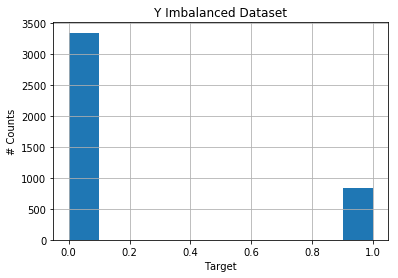

In [8]:
def plot_y_imbalance(y_vector):
    y_vector.hist()
    plt.title('Y Imbalanced Dataset')
    plt.xlabel('Target')
    plt.ylabel('# Counts')
    
plot_y_imbalance(y_train)

# Select only numeric values

In [9]:
# Select only the numeric inputs
X_train = X_train.select_dtypes(include=[np.number])
X_cv = X_cv.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])
test = test.select_dtypes(include=[np.number])

# Apply the Classifier

In [10]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

logit_clf = LogisticRegression(random_state=0)
logit_clf.fit(X_train,y_train)
probas = logit_clf.predict_proba(X_test)[:, 1]

# Get the In Sample Score

In [11]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, probas)

0.8510542962572483

# Predict the submission file

In [12]:
test

,AmountRain,StrongWindSpeed,AfternoonWindSpeed,MorningHumidity,AfternoonHumidity,MorningTemp,AfternoonTemp,DaysSinceNewYear
0,0.0,56.0,35.0,77.0,70.0,24.9,27.0,1
1,0.0,39.0,22.0,34.0,12.0,18.6,27.9,264
2,0.0,24.0,11.0,53.0,46.0,22.6,24.0,117
3,0.0,46.0,20.0,27.0,16.0,34.1,40.5,4
4,0.0,39.0,22.0,55.0,34.0,14.8,19.9,258
5,0.0,44.0,26.0,67.0,66.0,24.4,24.9,328
6,0.0,41.0,20.0,23.0,16.0,29.8,38.7,11
7,0.0,52.0,11.0,65.0,31.0,10.5,19.1,134
8,0.0,33.0,17.0,65.0,50.0,12.3,17.8,221
9,0.2,31.0,15.0,82.0,36.0,24.5,34.0,80


In [13]:
final_probas = logit_clf.predict_proba(test)

In [14]:
final_probas

array([[0.18010991, 0.81989009],
       [0.98975713, 0.01024287],
       [0.91284243, 0.08715757],
       ...,
       [0.9519738 , 0.0480262 ],
       [0.79526233, 0.20473767],
       [0.93254107, 0.06745893]])